/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_66935/4265740932.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ef['email'][x] = 'joe.person@wustl.edu'


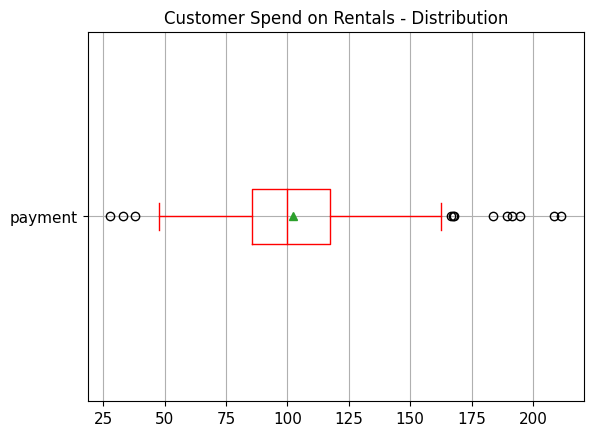

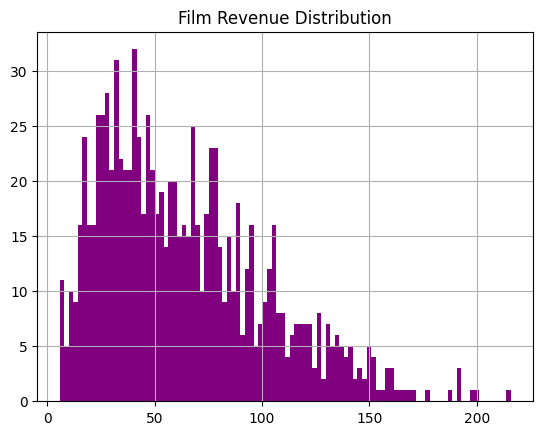

             0      1
0  10913543.12      G
1  11894535.76     PG
2  11955847.80      R
3  12875528.40  NC-17
4  13672584.92  PG-13
       Category  Store 1
0        Action      510
1     Animation      544
2      Children      411
3      Classics      427
4        Comedy      427
5   Documentary      473
6         Drama      498
7        Family      492
8       Foreign      464
9         Games      421
10       Horror      394
11        Music      387
12          New      409
13       Sci-Fi      505
14       Sports      544
15       Travel      386
       Category  Store 2
0        Action      503
1     Animation      521
2      Children      450
3      Classics      433
4        Comedy      424
5   Documentary      464
6         Drama      455
7        Family      496
8       Foreign      489
9         Games      463
10       Horror      379
11        Music      363
12          New      455
13       Sci-Fi      493
14       Sports      537
15       Travel      379
  husband revenue


In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

#Section 1 part 1: Connect to your local postgres instance from python
conn = psycopg2.connect(database="dvdrental",
                        host="localhost",
                        user="postgres",
                        password = "password")

#Section 1 part 2: query to return dataset and create a dataframe with queried data.

#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT title, rental_duration, rental_rate FROM film")

#Save into query_results1
query_results1 = cursor.fetchall()

#Create dataframe
df=pd.DataFrame(query_results1, columns = ['movie title', 'rental duration','rental rate'])


#Section 1 part 3, create a dataframe from the customer table

#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT*FROM customer")
#Save into query_results2
query_results2 = cursor.fetchall()
#Create dataframe
ef=pd.DataFrame(query_results2, columns = ['customer_id', 'store_id','first_name',
                                          'last_name','email','address_id','activebool',
                                          'create_date','last_update','active'])

#section 2 part 1: Adding the customer_name column
ef['customer_name'] = (ef['first_name'] + ' ' + ef['last_name'])

#Section 2 part 2: Removing inactive customers from dataframe
ef = ef.drop(ef.index[ef['active'] == 0])

#section 2 part 3
for x in ef.index[ef['store_id'] % 2 == 0]:
    ef['email'][x] = 'joe.person@wustl.edu'

#Section 3 part 1: Find how much customers tend to spend on rentals in aggregate

#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT SUM(payment.amount) as payment\
 FROM customer, payment\
 WHERE customer.customer_id = payment.customer_id\
 GROUP BY customer.customer_id")
 
#Save into query_results3
query_results3 = cursor.fetchall()

#Create dataframe
ff = pd.DataFrame(query_results3, columns = ['payment'])

#Converts column to numeric
ff['payment']=ff['payment'].astype(float)

#Plots the boxplot
ff.boxplot(showmeans=True,vert=False, color = 'red', fontsize = 11)
plt.title('Customer Spend on Rentals - Distribution')
plt.show()

#Section 3 part 2: Plot the distribution of film revenue

#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT SUM(payment.amount) as revenue\
 FROM film, inventory, payment, rental\
 WHERE film.film_id = inventory.film_id and\
 rental.inventory_id = inventory.inventory_id and\
 rental.rental_id = payment.rental_id\
 GROUP BY film.title")
 
#Save into query_results4
query_results4 = cursor.fetchall()

#Create dataframe
gg = pd.DataFrame(query_results4, columns = ['revenue'])
 
#Converts the column to numeric
gg['revenue']=gg['revenue'].astype(float)

#Plots the distribution of film revenue
gg.hist(bins=100, color = 'purple' )
plt.title('Film Revenue Distribution')
plt.show()

#Section 4 part 1: On average, do some movie ratings generate more revenue than others?
#Answer: Yes, PG-13 earns the most follows by NC-17, then R, then PG, and finally G
#See script below:
    
#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT SUM(payment.amount) as revenue, film.rating\
 FROM film, inventory, payment, rental\
 WHERE rental.inventory_id = inventory.inventory_id and\
 rental.rental_id = payment.rental_id\
 GROUP BY film.rating\
 ORDER BY revenue")
 
 #Save into query_results5
query_results5 = cursor.fetchall()

#Create dataframe
hh = pd.DataFrame(query_results5)

#Sort valeus in dataframe by ascending values
hh.sort_values(by=0, ascending=True)

#Print results
print(hh)

#Section 4 part 2: Do distributions of counts of rented films by category_id 
#look the same for the 2 stores? 
#Answer: It appears the distributions are very similar, although not quite exact.
#See script below:
    
#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT category.name,\
 COUNT(payment.payment_id)\
 FROM category, film_category, inventory, rental, payment\
 WHERE payment.staff_id = 1 AND\
 category.category_id = film_category.category_id\
 AND film_category.film_id = inventory.film_id\
 AND inventory.inventory_id = rental.inventory_id\
 AND rental.rental_id = payment.rental_id\
 GROUP BY category.name\
 ORDER BY category.name")
 
#Save into query_results_store1
query_results_store1 = cursor.fetchall()

#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT category.name,\
 COUNT(payment.payment_id)\
 FROM category, film_category, inventory, rental, payment\
 WHERE payment.staff_id = 2 AND\
 category.category_id = film_category.category_id\
 AND film_category.film_id = inventory.film_id\
 AND inventory.inventory_id = rental.inventory_id\
 AND rental.rental_id = payment.rental_id\
 GROUP BY category.name\
 ORDER BY category.name")
 
#Save into query_results_store1
query_results_store2 = cursor.fetchall()

#Create dataframes
ii = pd.DataFrame(query_results_store1, columns = ['Category','Store 1'])
jj = pd.DataFrame(query_results_store2, columns = ['Category','Store 2'])

#Print results
print(ii)
print(jj)

#Section 4 part 3: Do films that have a ‘husband’ (check the ‘fulltext’ field)
#generate the same amount of revenue 
#as films that feature a ‘dinosaur’? 
#Answer: No, husband generates $5553 and dinosaur generates $223
#See script below:
cursor = conn.cursor()
cursor.execute("SELECT SUM(payment.amount) as revenue\
 FROM film, inventory, payment, rental\
 WHERE film.fulltext @@ to_tsquery('%husband%')\
 AND film.film_id = inventory.film_id\
 AND inventory.inventory_id = rental.inventory_id\
 AND rental.rental_id = payment.rental_id")

#Save into query_results_husband
query_results_husband= cursor.fetchall()

#Execute SQL commands to extract desired dataset
cursor = conn.cursor()
cursor.execute("SELECT SUM(payment.amount) as revenue\
 FROM film, inventory, payment, rental\
 WHERE film.fulltext @@ to_tsquery('%dinosaur%')\
 AND film.film_id = inventory.film_id\
 AND inventory.inventory_id = rental.inventory_id\
 AND rental.rental_id = payment.rental_id")
 
#Save into query_results_dinosaur
query_results_dinosaur= cursor.fetchall()

#Create dataframes
kk = pd.DataFrame(query_results_husband, columns = ['husband revenue'])
ll = pd.DataFrame(query_results_dinosaur, columns = ['dinosaur revenue'])

#Print results
print(kk)
print(ll)